In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    geno_palette,
    syllable_aliases,
    clean_ticks,
    savefig
)
import pandas as pd

import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load in raw data and normalize

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [5]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]

In [7]:
feedback_df = pd.read_parquet(
    os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet"),
    filters=[
        ("experiment_type", "=", "reinforcement"),
        ("area", "in", ["snc (axon)", "ctrl"]),
    ],
).sort_index()

In [8]:
feedback_df = feedback_df.loc[
    (feedback_df["area"].isin(["snc (axon)", "ctrl"]))
    & (feedback_df["opsin"].isin(["chr2", "ctrl"]))
    & (feedback_df["stim_duration"] == 0.25)
    & (feedback_df["target_syllable"].isin(syllable_aliases.keys()))
].copy()

IOStream.flush timed out


In [9]:
meta_df = feedback_df.drop_duplicates(["syllable_group", "date"])

In [10]:
cnts = meta_df.groupby(["mouse_id", "stim_duration", "target_syllable"])[
    "syllable_group"
].nunique()

In [11]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(cnts[cnts > 1])

Series([], Name: syllable_group, dtype: int64)

## Load normalized dataframe

In [12]:
norm_df = pd.read_parquet(
    os.path.join(
        raw_dirs["closed_loop_behavior"], "learning_aggregate.parquet"
    )
)

## Now average velocity for all syllables

In [14]:
scalar_keys = ["velocity_2d_mm"]

In [15]:
for _key in scalar_keys:
    z_key = f"{_key}_z"
    feedback_df[z_key] = feedback_df.groupby(["uuid", "session_number"])[
        _key
    ].transform(lambda x: (x - x.mean()) / x.std())

In [16]:
z_keys = [f"{_key}_z" for _key in scalar_keys]

In [17]:
scalar_ave_df = (
    feedback_df.loc[feedback_df["session_number"].isin([1, 2])]
    .groupby(["uuid", "target_syllable", "predicted_syllable"])[scalar_keys + z_keys]
    .mean()
)
scalar_ave_df = scalar_ave_df.reset_index()

In [18]:
target_velocities = scalar_ave_df.groupby("uuid").apply(
    lambda x: x.loc[x["target_syllable"] == x["predicted_syllable"]]["velocity_2d_mm_z"]
)
target_velocities.index = target_velocities.index.droplevel(-1)

In [19]:
scalar_ave_df["target_velocity"] = scalar_ave_df["uuid"].map(target_velocities)
scalar_ave_df["velocity_diff"] = (
    scalar_ave_df["velocity_2d_mm_z"] - scalar_ave_df["target_velocity"]
)

In [20]:
scalar_ave_df.rename(columns={"predicted_syllable": "syllable"}, inplace=True)

In [21]:
scalar_df = pd.merge(
    norm_df,
    scalar_ave_df[["velocity_diff", "uuid", "syllable"]],
    on=["uuid", "syllable"],
    how="left",
)

In [22]:
vel_diff_bins = pd.qcut(scalar_df["velocity_diff"], 10)

In [23]:
scalar_df["is_target"] = scalar_df["syllable"] == scalar_df["target_syllable"]
scalar_df["velocity_diff_bin"] = vel_diff_bins

In [24]:
total_df = (
    scalar_df.loc[(scalar_df["session_number"].isin([1, 2]))]
    .groupby(
        [
            "mouse_id",
            "syllable",
            "session_number",
            "target_syllable",
            "area",
            "stim_duration",
            "velocity_diff_bin",
        ],
        observed=True,
    )["change_count"]
    .sum()
)

In [25]:
total_df = total_df.reset_index()

In [26]:
total_df["is_target"] = total_df["syllable"] == total_df["target_syllable"]

In [27]:
learner_dct = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "closed_loop_learners.toml")
)
learners = learner_dct["snc (axon)"]["learners"]

In [28]:
total_df["learner"] = total_df["mouse_id"].isin(learners)
total_df["learner"] = total_df["learner"].map({True: "yes", False: "no"})
total_df.loc[total_df["area"] == "ctrl", "learner"] = "ctrl"

In [29]:
plt_df = (
    total_df.groupby(
        [
            "is_target",
            "learner",
            "mouse_id",
            "area",
            "session_number",
            "velocity_diff_bin",
        ],
        observed=True,
    )
    .mean()
    .xs(False, level="is_target")
    .reset_index()
)

In [30]:
setup_plotting_env()

In [31]:
sns.set_context("paper")

In [32]:
nshuffles = 1000
shuffle_groupby = [
    "area",
    "stim_duration",
    "session_number",
    "target_syllable",
]
ave_groupby = ["area", "stim_duration", "session_number", "velocity_diff_bin"]
shuffle_key = "change_count"
shuffles = []
for i in tqdm(range(nshuffles)):
    _df = total_df.copy()
    _df[shuffle_key] = _df.groupby(shuffle_groupby)[shuffle_key].sample(frac=1).values
    _ave = _df.groupby(ave_groupby).mean(numeric_only=True)
    shuffles.append(_ave.reset_index())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
setup_plotting_env()

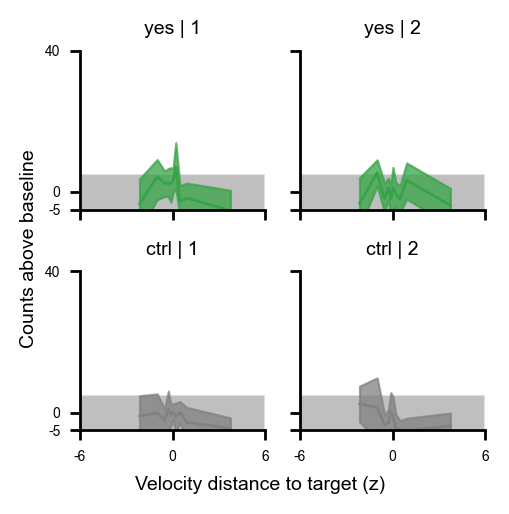

In [34]:
g = sns.relplot(
    data=plt_df,
    x=plt_df["velocity_diff_bin"].apply(lambda x: x.mid.astype("float")),
    y="change_count",
    col="session_number",
    row="learner",
    row_order=["yes", "ctrl"],
    height=1.25,
    aspect=1,
    hue="learner",
    err_kws={"alpha": 0.75},
    hue_order=["yes", "ctrl"],
    palette=[geno_palette.snc, geno_palette.ctrl],
    legend=False,
    kind="line",
)

g.set(ylim=(-5, 40), xlim=(-6, 6))
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set_axis_labels("", "")

g.fig.supylabel("Counts above baseline", fontsize=7)
g.fig.supxlabel("Velocity distance to target (z)", fontsize=7)

for _ax in g.axes.flat:
    _ax.fill_between(_ax.get_xlim(), -5, 5, facecolor=[0.5] * 3, alpha=0.5, zorder=-200)

clean_ticks(g.fig.axes[0], "y", dtype=int, precision=1, zero_symmetry=False)
clean_ticks(g.fig.axes[0], "x", dtype=int, precision=1, zero_symmetry=True)

g.fig.tight_layout(rect=[-0.05, -0.05, 1, 1])
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "velocity_diff_learning_learners-only"),
    bbox_inches="tight",
)
# g.fig.tight_layout()

In [35]:
plt_df_stats = plt_df.set_index(["learner", "session_number", "velocity_diff_bin"])

In [36]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [37]:
use_test = mannwhitneyu

In [38]:
dcts = []
for _bin in plt_df_stats.index.get_level_values("velocity_diff_bin"):
    for _session in [1, 2]:
        try:
            dat1 = plt_df_stats.xs(
                ("yes", _session, _bin),
                level=("learner", "session_number", "velocity_diff_bin"),
            )["change_count"]
            dat2 = plt_df_stats.xs(
                ("ctrl", _session, _bin),
                level=("learner", "session_number", "velocity_diff_bin"),
            )["change_count"]
        except KeyError:
            continue
        dct = {}

        stat, p = use_test(dat1, dat2)
        dct["lag"] = _bin
        dct["stat"] = stat
        dct["p"] = p
        dct["n1"] = len(dat1)
        dct["n2"] = len(dat2)
        dct["n_definition"] = "Per-mouse average"
        dct["test"] = str(use_test.__name__)
        dcts.append(dct)

In [39]:
pval_df = pd.DataFrame(dcts)

In [40]:
pval_df["p"] = multipletests(pval_df["p"], method="holm")[1]

In [41]:
import json

In [42]:
with open(
    os.path.join(proc_dirs["closed_loop_behavior"], "stats_velocity_diff.toml"), "w"
) as f:
    toml.dump(json.loads(pval_df.to_json()), f)

In [43]:
pval_df["p"].min()

1.0